# Introduction to Machine Learning Program Assignment #1
#### 0316313 張逸群

## Environment

- OS X El Capitan
- Intel Xeon Processor E3-1231 v3
    - 3.40 - 3.80 GHz,
    - 4 cores, 8 threads
    - 8M Cache
- 16GB DDR3 RAM

## Language

- python 3.5.2
- jupyter notebook
    
## Library

- scikit-learn
    - ``DecisionTreeClassifier``
    - ``confusion_matrix``
    - ``KFold``
    - ``RandomForestClassifier``
    - ``train_test_split``
- requests
- numpy
- csv
- matplotlib

## How to use this code

1. Open .ipynb with jupyter notebook
2. ``Kernel`` -> ``Restart & Run All``
3. View results below cells

Note! This program needs **Network** to download dataset!

## Results

1. [Resubstitution validation](#resub_result)
2. [K-Fold validation](#k_fold_result)
3. [Bagging decision tree(random-forest)](#random_result)

***
***

## Download dataset and convert it to ``list``

1. The iris dataset can be downloaded online using python ``requests.get`` model function.  
2. After ``get``, we'll have a ``response`` object which contrains a ``text`` string member.  
3. Using ``StringIO`` and ``csv.reader``, we'll eventually get a ``list`` data!  

In [1]:
# get data set using requests and convert it to csv
from io import StringIO
import requests
import csv

iris_site = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
iris_csv = csv.reader(StringIO(iris_site.text), delimiter=',')
iris_list = list(iris_csv)[:-1] # ignore last blank line

### Print first 5 row to check currectness

In [2]:
# check output
print( 'length of data:', len(iris_list))
for row in iris_list[:5]:
    print(row)

length of data: 150
['5.1', '3.5', '1.4', '0.2', 'Iris-setosa']
['4.9', '3.0', '1.4', '0.2', 'Iris-setosa']
['4.7', '3.2', '1.3', '0.2', 'Iris-setosa']
['4.6', '3.1', '1.5', '0.2', 'Iris-setosa']
['5.0', '3.6', '1.4', '0.2', 'Iris-setosa']


## Convert string label to index label

Using ``dict`` to convert string label to index label.

In [3]:
# convert 3 output class to index
index_so_far = 0
class2index = dict()
index2class = dict()
for i, row in enumerate(iris_list):
    if row[-1] not in class2index:
        class2index[ row[-1] ] = index_so_far
        index2class[index_so_far] = row[-1]
        index_so_far += 1
    iris_list[i][-1] = class2index[ row[-1] ]

In [4]:
# check correctness
print('Index to class:')
for i in range(3):
    print(i, ':', index2class[i])

print('\nAfter convertion:')
for row in iris_list[:5]:
    print(row)

Index to class:
0 : Iris-setosa
1 : Iris-versicolor
2 : Iris-virginica

After convertion:
['5.1', '3.5', '1.4', '0.2', 0]
['4.9', '3.0', '1.4', '0.2', 0]
['4.7', '3.2', '1.3', '0.2', 0]
['4.6', '3.1', '1.5', '0.2', 0]
['5.0', '3.6', '1.4', '0.2', 0]


## Using DecisionTreeClassifier to construct a decision-tree model

1. Import necessary models
2. Separate labels from data list
3. Use different ``min_samples_leaf`` option to do pruning
    1. ``min_samples_leaf`` guarantees minimal number of samples in one decision tree leaf
    2. which is so called __early stopping criteria__
4. Get all confusion matrixes for comparison

In [5]:
# do machine learning thing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np

x_whole = np.array(iris_list)[:,:-1]
y_whole = np.array(iris_list)[:,-1]

### Define function for resubstitution validation

1. Get a classifier
2. Fit it to `X` and `Y` training data
3. Get confustion matrix with __same training data__

In [6]:
def get_cm_resub(X, Y, msl):
    clf = DecisionTreeClassifier(min_samples_leaf=msl)
    clf.fit(X, Y)
    pred = clf.predict(X)
    true = Y
    return confusion_matrix(true, pred)

In [7]:
# resubstitution training

# get different confusion matrixes with different min_samples_leaf pruning
x_resub, y_resub = shuffle(x_whole, y_whole)
resub_cm_1 = get_cm_resub(x_resub, y_resub, 1)
resub_cm_3 = get_cm_resub(x_resub, y_resub, 3)
resub_cm_5 = get_cm_resub(x_resub, y_resub, 5)

### Define function for K-Fold validation

1. Use `KFold` function to get K-Fold splits
2. Get training and testing data for each fold and fit them to a classifier
3. Sum up all confusion matrixes for every classifier
4. Return final confusion matrixes

In [8]:
from sklearn.model_selection import KFold
def get_cm_kfold(X, Y, msl, K=3):
    rtn_cm = np.zeros((3,3))
    kf = KFold(n_splits=K)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf = DecisionTreeClassifier(min_samples_leaf=msl)
        clf.fit(X_train, Y_train)
        # get confusion matrix
        pred = clf.predict(X_test)
        rtn_cm += np.array(confusion_matrix(Y_test, pred))
    return rtn_cm

In [9]:
x_kfold, y_kfold = shuffle(x_whole, y_whole)
kfold_cm_1 = get_cm_kfold(x_kfold, y_kfold, 1)
kfold_cm_3 = get_cm_kfold(x_kfold, y_kfold, 3)
kfold_cm_5 = get_cm_kfold(x_kfold, y_kfold, 5)

## Visualization

1. We first define a function to plot a confusion matrix
2. We then use ths function to plot all confusion matrixes for comparison

### Confusion matrix ploting function

This function is designed by [confusion_matrix site](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py).

In [10]:
# visualization
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 4)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Results

### Resubstitution validation <a name="resub_result"></a>

Although we use early stopping pruning with min_samples_leaf,  
the result in **min_leaf=1** is the best one.  
  
The more we prune, the larger error we get.  

  
This might be because resubstitution validation is using the  
same set of data for training and testing, pruning will only  
result in inaccurate classification.

resubstitution:


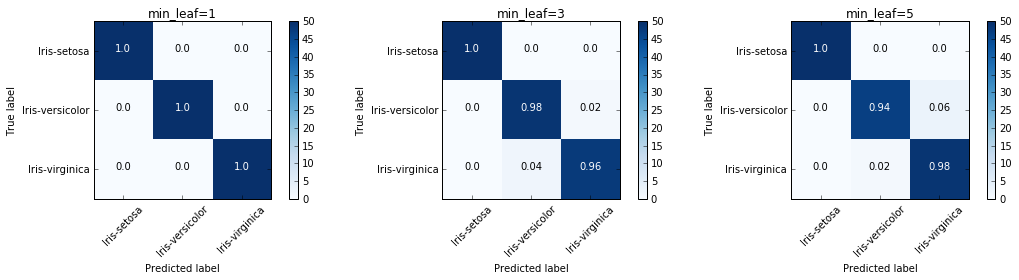

In [11]:
class_names = [ index2class[0], index2class[1], index2class[2] ]

print('resubstitution:')
plt.figure()
plt.subplot(131)
plot_confusion_matrix(resub_cm_1, classes=class_names, normalize=True,
                      title='min_leaf=1')
plt.subplot(132)
plot_confusion_matrix(resub_cm_3, classes=class_names, normalize=True,
                      title='min_leaf=3')
plt.subplot(133)
plot_confusion_matrix(resub_cm_5, classes=class_names, normalize=True,
                      title='min_leaf=5')

### K-Fold Validation <a name="k_fold_result"></a>

In K-Fold validation, pruning is slightly beneficial.  
The difference is, however, so little (__0.02__). It's hard  
to say if early stopping pruning is actually helpful  
in this dataset.

k-fold, K=3:


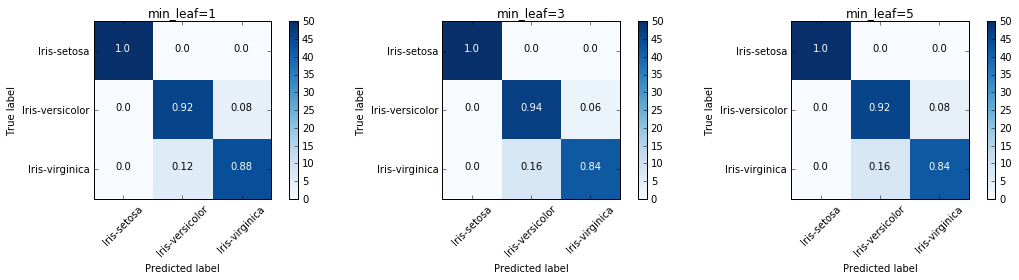

In [12]:
print('k-fold, K=3:')

plt.figure()
plt.subplot(131)
plot_confusion_matrix(kfold_cm_1, classes=class_names, normalize=True,
                      title='min_leaf=1')
plt.subplot(132)
plot_confusion_matrix(kfold_cm_3, classes=class_names, normalize=True,
                      title='min_leaf=3')
plt.subplot(133)
plot_confusion_matrix(kfold_cm_5, classes=class_names, normalize=True,
                      title='min_leaf=5')

### Bagging decision tree(random-forest) <a name="random_result"></a>

> A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

As we can see, the result with random forest classifier is not better than  
the standerd decision tree classifier.  
Perhaps it's because the __simplicity__ of the data, random forest doesn't  
achieve its full potential.

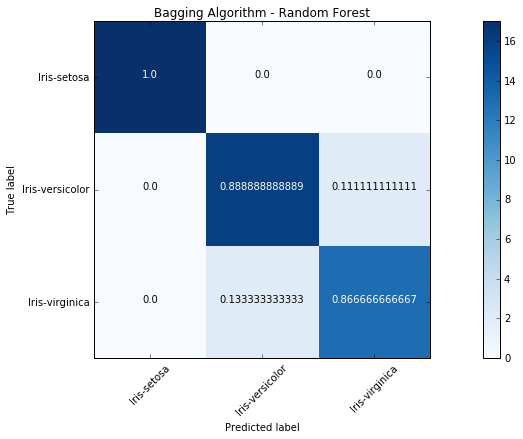

In [13]:
# bagging decision tree, random forest
pylab.rcParams['figure.figsize'] = (15, 6)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

x_rf_train, x_rf_test, y_rf_train, y_rf_test = train_test_split(x_whole, y_whole, test_size=0.33)
rf_clf = RandomForestClassifier()
rf_clf.fit(x_rf_train, y_rf_train)
# get confusion matrix and plot it
cm_rf = confusion_matrix( y_rf_test, rf_clf.predict(x_rf_test) )
plt.figure()
plot_confusion_matrix(np.array(cm_rf), classes=class_names, normalize=True,
                      title='Bagging Algorithm - Random Forest')